In [3]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed.
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)),
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)

    def fullp (self):
        return len(self.dictionary) >= self.size

    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


In [4]:
import numpy as np

class Tilecoder:
    def __init__(self, min_position, max_position, min_velocity, max_velocity,
     iht_size = 4096, num_tilings = 8, num_tiles = 4):
        self.iht = IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.min_velocity = min_velocity
        self.max_velocity = max_velocity
        self.min_position = min_position
        self.max_position = max_position

    def get_tiles(self, state):
        position, velocity = state[0], state[1]
        position_scaled = (position - self.min_position) / (self.max_position - self.min_position) * self.num_tiles
  

        velocity_scaled = (velocity - self.min_velocity) / (self.max_velocity - self.min_velocity) * self.num_tiles
        t = tiles(self.iht, self.num_tilings, [position_scaled, velocity_scaled])
        return np.array(t)

class ReinforceAgent:
    def agent_init(self, agent_info = {}, adam_info = {}):
        min_position = agent_info.get('min_position')
        max_position = agent_info.get('max_position')
        min_velocity = agent_info.get('min_velocity')
        max_velocity = agent_info.get('max_velocity')
        self.iht_size = agent_info.get('iht_size')
        self.num_tilings = agent_info.get('num_tilings')
        self.num_tiles = agent_info.get('num_tiles')
        self.step_size = agent_info.get('step_size')
        self.discount_factor = agent_info.get('discount_factor')
        self.num_actions = agent_info.get('num_actions')
        self.T = agent_info.get('temperature')

        self.theta = np.random.uniform(low=-0.001, high=0.001, size=(self.num_actions * self.iht_size, ))

        # For Fixing Left and Right action initially
        #self.theta[0:self.iht_size] = 1
        #self.theta[self.iht_size*2:] = 1

        self.tilecoder = Tilecoder(min_position, max_position, min_velocity, max_velocity,
        iht_size = self.iht_size, num_tilings = self.num_tilings, num_tiles = self.num_tiles)

    def agent_step(self, state):
        action = self.policy(state)
        return action

    def agent_end(reward):
        pass

    def get_state_action_feature(self, state, action):
        """
        Take state and action as input, encode it through tile coding and stack it to produce feature
        action = [0,1,2]
        """
        active_tile = self.tilecoder.get_tiles(state)
        active_feature_per_action = np.zeros((self.iht_size, ))
        active_feature_per_action[active_tile] = 1
        active_state_action_feature = np.zeros((self.num_actions * self.iht_size, ))
        active_state_action_feature[self.iht_size * action:self.iht_size * (action+1)] = active_feature_per_action
        return active_state_action_feature

    def get_action_value(self, active_state_action_feature):
        action_value = np.dot(self.theta, active_state_action_feature)
        return action_value

    def softmax(self, state):
        preferences = []
        for a in range(self.num_actions):
            active_state_action_feature = self.get_state_action_feature(state, a)
            action_value = self.get_action_value(active_state_action_feature)
            preferences.append(action_value)
        preferences = np.array(preferences)
        max_preferences = np.max(preferences)
        preferences = (preferences - max_preferences)/self.T
        exp_preferences = np.exp(preferences)
        sum_exp_preferences  = np.sum(exp_preferences)
        action_probs = exp_preferences / sum_exp_preferences
        return action_probs

    def policy(self, state):
        action_probs = self.softmax(state)
        #print(action_probs)
        action = np.random.choice(self.num_actions, p=action_probs)
        return action

    def get_gradient(self, state, action):
        active_state_action_feature = self.get_state_action_feature(state, action)
        action_probs = self.softmax(state)

        feature_set = []
        for a in range(self.num_actions):
            feature = self.get_state_action_feature(state, a)
            feature_set.append(feature)
        feature_set = np.array(feature_set)
        expected_feature_value = np.dot(action_probs, feature_set)


        gradient = active_state_action_feature - expected_feature_value
        return gradient

    def update_weight(self, action, state, g, t):
        gradient = self.get_gradient(state, action)
        self.theta = self.theta + self.step_size * (self.discount_factor ** t) * g * gradient


Trial: 1


/Users/saadrahman/Reinforcement Learning/untitled folder/.venv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10


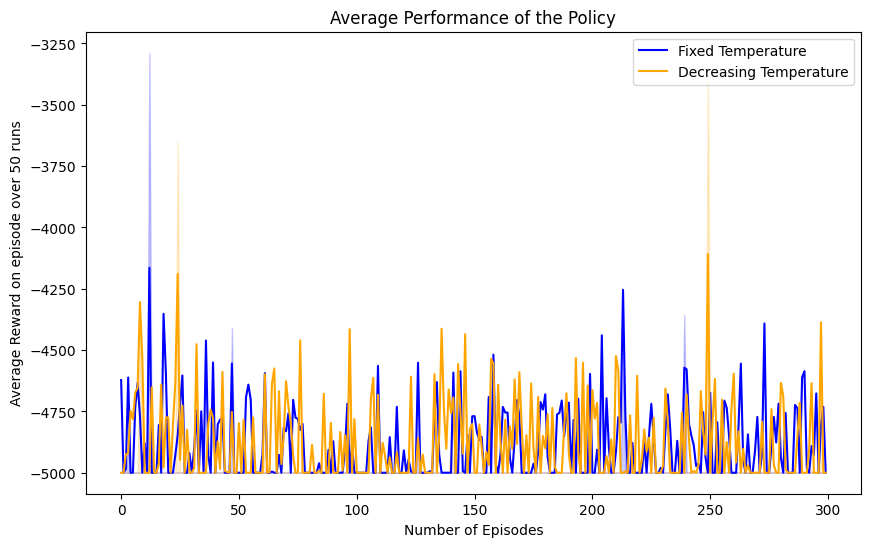

In [8]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from pathos.multiprocessing import ProcessingPool as Pool
# models = [REINFORCE, ActorCritic]



# Initialize environment
env=gym.make('MountainCar-v0', max_episode_steps=5000)
min_position, min_velocity = env.observation_space.low
max_position, max_velocity = env.observation_space.high

# Define parameters
num_episode = 300  # Number of episodes per trial
num_trials = 10     # Number of trials
fixed_temperature = 5  # Fixed temperature for the first configuration
initial_temperature = 5  # Initial temperature for the second configuration

# Initialize results arrays
results_fixed_temp = np.zeros((num_trials, num_episode))
results_dec_temp = np.zeros((num_trials, num_episode))

for trial in range(num_trials):
    print(f'Trial: {trial + 1}')

    # Initialize REINFORCE agent with fixed temperature
    agent_fixed_temp = ReinforceAgent()
    agent_fixed_temp.agent_init({
        'min_position': min_position, 'min_velocity': min_velocity,
        'max_position': max_position, 'max_velocity': max_velocity,
        'num_actions': env.action_space.n, 'iht_size': 2048,
        'num_tilings': 16, 'num_tiles': 10,
        'step_size': 2e-8, 'discount_factor': 0.99,
        'temperature': fixed_temperature  # Fixed temperature
    })

    # Initialize REINFORCE agent with decreasing temperature
    agent_dec_temp = ReinforceAgent()
    agent_dec_temp.agent_init({
        'min_position': min_position, 'min_velocity': min_velocity,
        'max_position': max_position, 'max_velocity': max_velocity,
        'num_actions': env.action_space.n, 'iht_size': 2048,
        'num_tilings': 16, 'num_tiles': 10,
        'step_size': 2e-8, 'discount_factor': 0.99,
        'temperature': initial_temperature  # Decreasing temperature
    })

    # Episodes rollout for fixed temperature
    for episode in range(num_episode):

        # Generate_episodes
        state_ls = []
        action_ls = []
        reward_ls = []

        
        total_reward = 0
        state, inf = env.reset()
        done = False
        while not done:
            action = agent_fixed_temp.agent_step(state)
            state_ls.append(state)
            action_ls.append(action)
            # print(env.state(action))
            state, reward, terminal, truncated, info = env.step(action)
            total_reward += reward
            reward_ls.append(reward)
            done = terminal or truncated
        results_fixed_temp[trial, episode] = total_reward
        


        

        for t in range(len(reward_ls)):
            g = 0
            power_arr = np.arange(t+1, len(state_ls))
            agent_discount_factor_arr = np.array([agent_fixed_temp.discount_factor] * len(power_arr))
            reward_arr = np.array(reward_ls[t:len(state_ls)-1])
            g = np.power(agent_discount_factor_arr, power_arr)
            g = np.dot(g, reward_arr)

            state = state_ls[t]
            action = action_ls[t]
            agent_fixed_temp.update_weight(action, state, g, t)
        




   
   
   
   
   
   
   
   
   
   
   
    # Episodes rollout for decreasing temperature
    for episode in range(num_episode):
        agent_dec_temp.T = agent_dec_temp.T*0.99

        # Generate_episodes
        state_ls = []
        action_ls = []
        reward_ls = []

        
        total_reward = 0
        state, inf = env.reset()
        done = False
        while not done:
            action = agent_dec_temp.agent_step(state)
            state_ls.append(state)
            action_ls.append(action)
            # print(env.state(action))
            state, reward, terminal, truncated, info = env.step(action)
            total_reward += reward
            reward_ls.append(reward)
            done = terminal or truncated
        results_dec_temp[trial, episode] = total_reward
        


        

        for t in range(len(reward_ls)):
            g2 = 0
            power_arr2 = np.arange(t+1, len(state_ls))
            agent_discount_factor_arr2 = np.array([agent_dec_temp.discount_factor] * len(power_arr2))
            reward_arr2 = np.array(reward_ls[t:len(state_ls)-1])
            g2 = np.power(agent_discount_factor_arr2, power_arr2)
            g2 = np.dot(g2, reward_arr2)

            state = state_ls[t]
            action = action_ls[t]
            agent_dec_temp.update_weight(action, state, g2, t)
        

# Calculate mean and interquantile range
mean_fixed_temp = np.mean(results_fixed_temp, axis=0)
mean_dec_temp = np.mean(results_dec_temp, axis=0)
quantiles_fixed_temp = np.percentile(results_fixed_temp, [25, 75], axis=0)
quantiles_dec_temp = np.percentile(results_dec_temp, [25, 75], axis=0)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(num_episode), mean_fixed_temp, label='Fixed Temperature', color='blue')
plt.fill_between(range(num_episode), quantiles_fixed_temp[0], quantiles_fixed_temp[1], color='blue', alpha=0.2)
plt.plot(range(num_episode), mean_dec_temp, label='Decreasing Temperature', color='orange')
plt.fill_between(range(num_episode), quantiles_dec_temp[0], quantiles_dec_temp[1], color='orange', alpha=0.2)
plt.xlabel('Number of Episodes')
plt.ylabel('Average Reward on episode over 50 runs')
plt.title('Average Performance of the Policy')
plt.legend()
plt.show()

env.close()


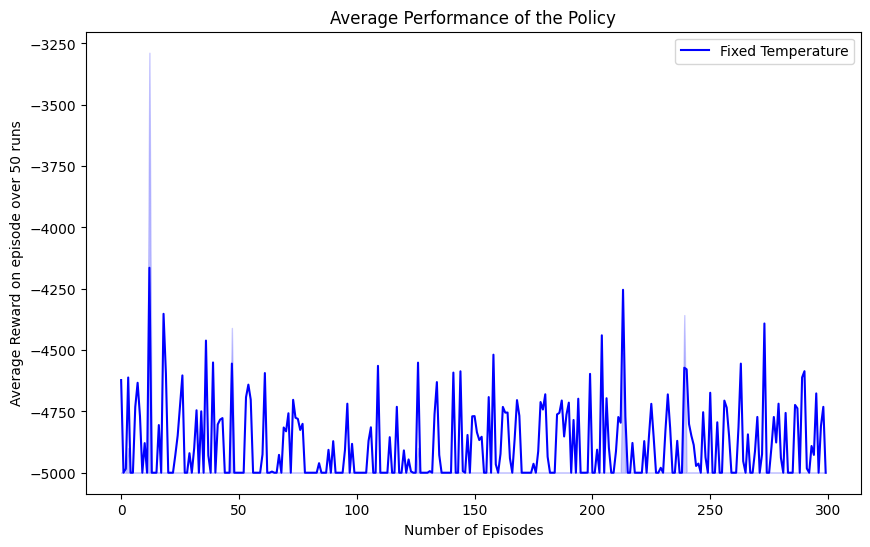

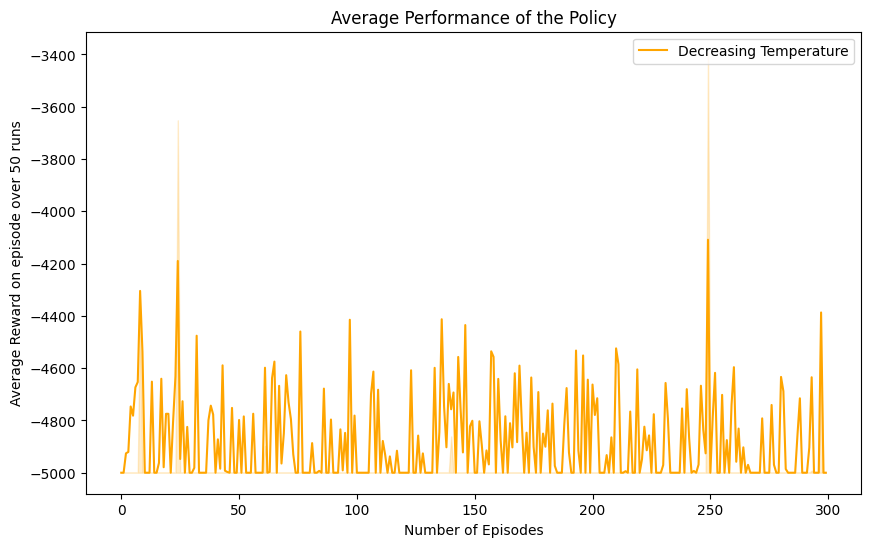

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_episode), mean_fixed_temp, label='Fixed Temperature', color='blue')
plt.fill_between(range(num_episode), quantiles_fixed_temp[0], quantiles_fixed_temp[1], color='blue', alpha=0.2)
plt.xlabel('Number of Episodes')
plt.ylabel('Average Reward on episode over 50 runs')
plt.title('Average Performance of the Policy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(num_episode), mean_dec_temp, label='Decreasing Temperature', color='orange')
plt.fill_between(range(num_episode), quantiles_dec_temp[0], quantiles_dec_temp[1], color='orange', alpha=0.2)
plt.xlabel('Number of Episodes')
plt.ylabel('Average Reward on episode over 50 runs')
plt.title('Average Performance of the Policy')
plt.legend()
plt.show()

For both Fixed and Decaying Temperature configurations, the following hyperparameters were used after running several experiments:
Maximum time steps per episode = 5000, Number of tiles per dimension = 10, Number of tilings = 10, Learning rate = 2e-8, Discount Factor = 0.99
For both configurations, we can see that the REINFORCE agent is not really learning to perform significantly better overtime. However, we can see that the configuration with decaying temperature slightly performs better than the fixed temperature as seen by the peaks in the later episodes. Note that we have limited the number of episodes to 300 instead of 1000 due to the extremely high computational time that was required in running the model. This particular experiment took approximately 13 hours to complete with the resources we had, even if we were just using 5000 timesteps and 300 episodes. We suspect that with a higher number of timesteps per episode (around 10000) and 1000 episodes, the agent might learn to perform better. Furthermore, we believe that REINFORCE with Baseline would perform better than the current agent due to the reduced variance.